# ITS_LIVE: calculate Metric 1

This notebook calculates $\delta_u$ and $\delta_v$ for all ITS_LIVE velocity maps.

To reproduce this workflow, make sure you have downloaded all necessary input files (velocity maps and static terrain geometries) from https://doi.org/10.17605/OSF.IO/HE7YR and have updated the `Vx` and `Vy` columns in `notebooks/results_ITSLIVE.csv` or `notebooks/manifest_ITSLIVE.csv` with the downloaded file paths before starting the analysis.

In [1]:
import glaft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc

In [2]:
# df = pd.read_csv('../manifest_ITSLIVE.csv', dtype=str)
df = pd.read_csv('../results_ITSLIVE.csv', dtype=str)
# df

In [7]:
# static area
in_shp = '/home/jovyan/Projects/PX_comparison/shapefiles/bedrock_V2_EPSG3413.shp'

Locate the assigned error value in the metadata of the original NetCDF files:

In [3]:
for idx, row in df.iterrows():
    ncfname_processed = row.Vx[:-7]
    ncfname_list = ncfname_processed.split('/')
    ncfname_list.append(ncfname_list[-1])
    ncfname_list[-2] = 'raw_nc'
    ncfname = '/'.join(ncfname_list)
    with nc.Dataset(ncfname) as ds:
        vxd = ds['vx']
        xe = vxd.__dict__['error']
        # print(xe)
        vyd = ds['vy']
        ye = vyd.__dict__['error']
        # print(ye)
        df.loc[idx, 'Assigned-x-error'] = xe
        df.loc[idx, 'Assigned-y-error'] = ye
        
# df

Here's a demo for calculating Metric 1 for an ITS_LIVE velocity map:

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent


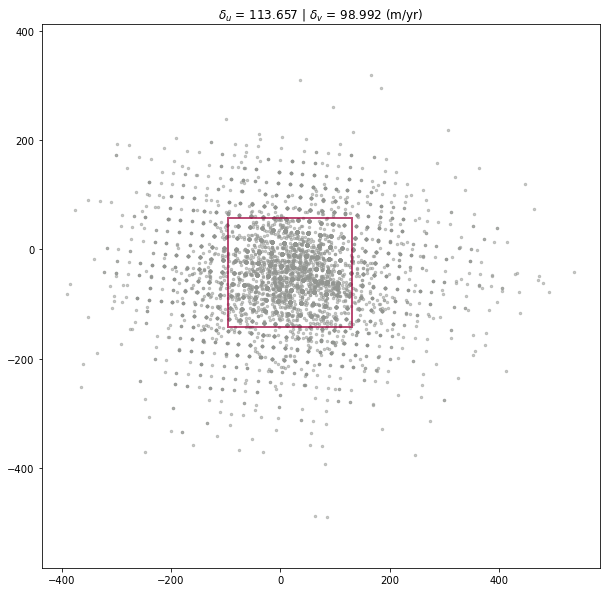

In [8]:
exp = glaft.Velocity(vxfile=df.loc[4, 'Vx'], vyfile=df.loc[4, 'Vy'], 
                     static_area=in_shp, kde_gridsize=60, thres_sigma=2.0, 
                     velocity_unit='m/yr')
exp.static_terrain_analysis(plot='full')

Now let's batch process all the maps:

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
xstd: 39.496883392333984; xSAVuncer: 51.14884809068558
ystd: 33.03361511230469; ySAVuncer: 44.548996724145496
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
xstd: 121.10285186767578; xSAVuncer: 124.23576847338722
ystd: 82.7453384399414; ySAVuncer: 108.70629741421381
Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_me

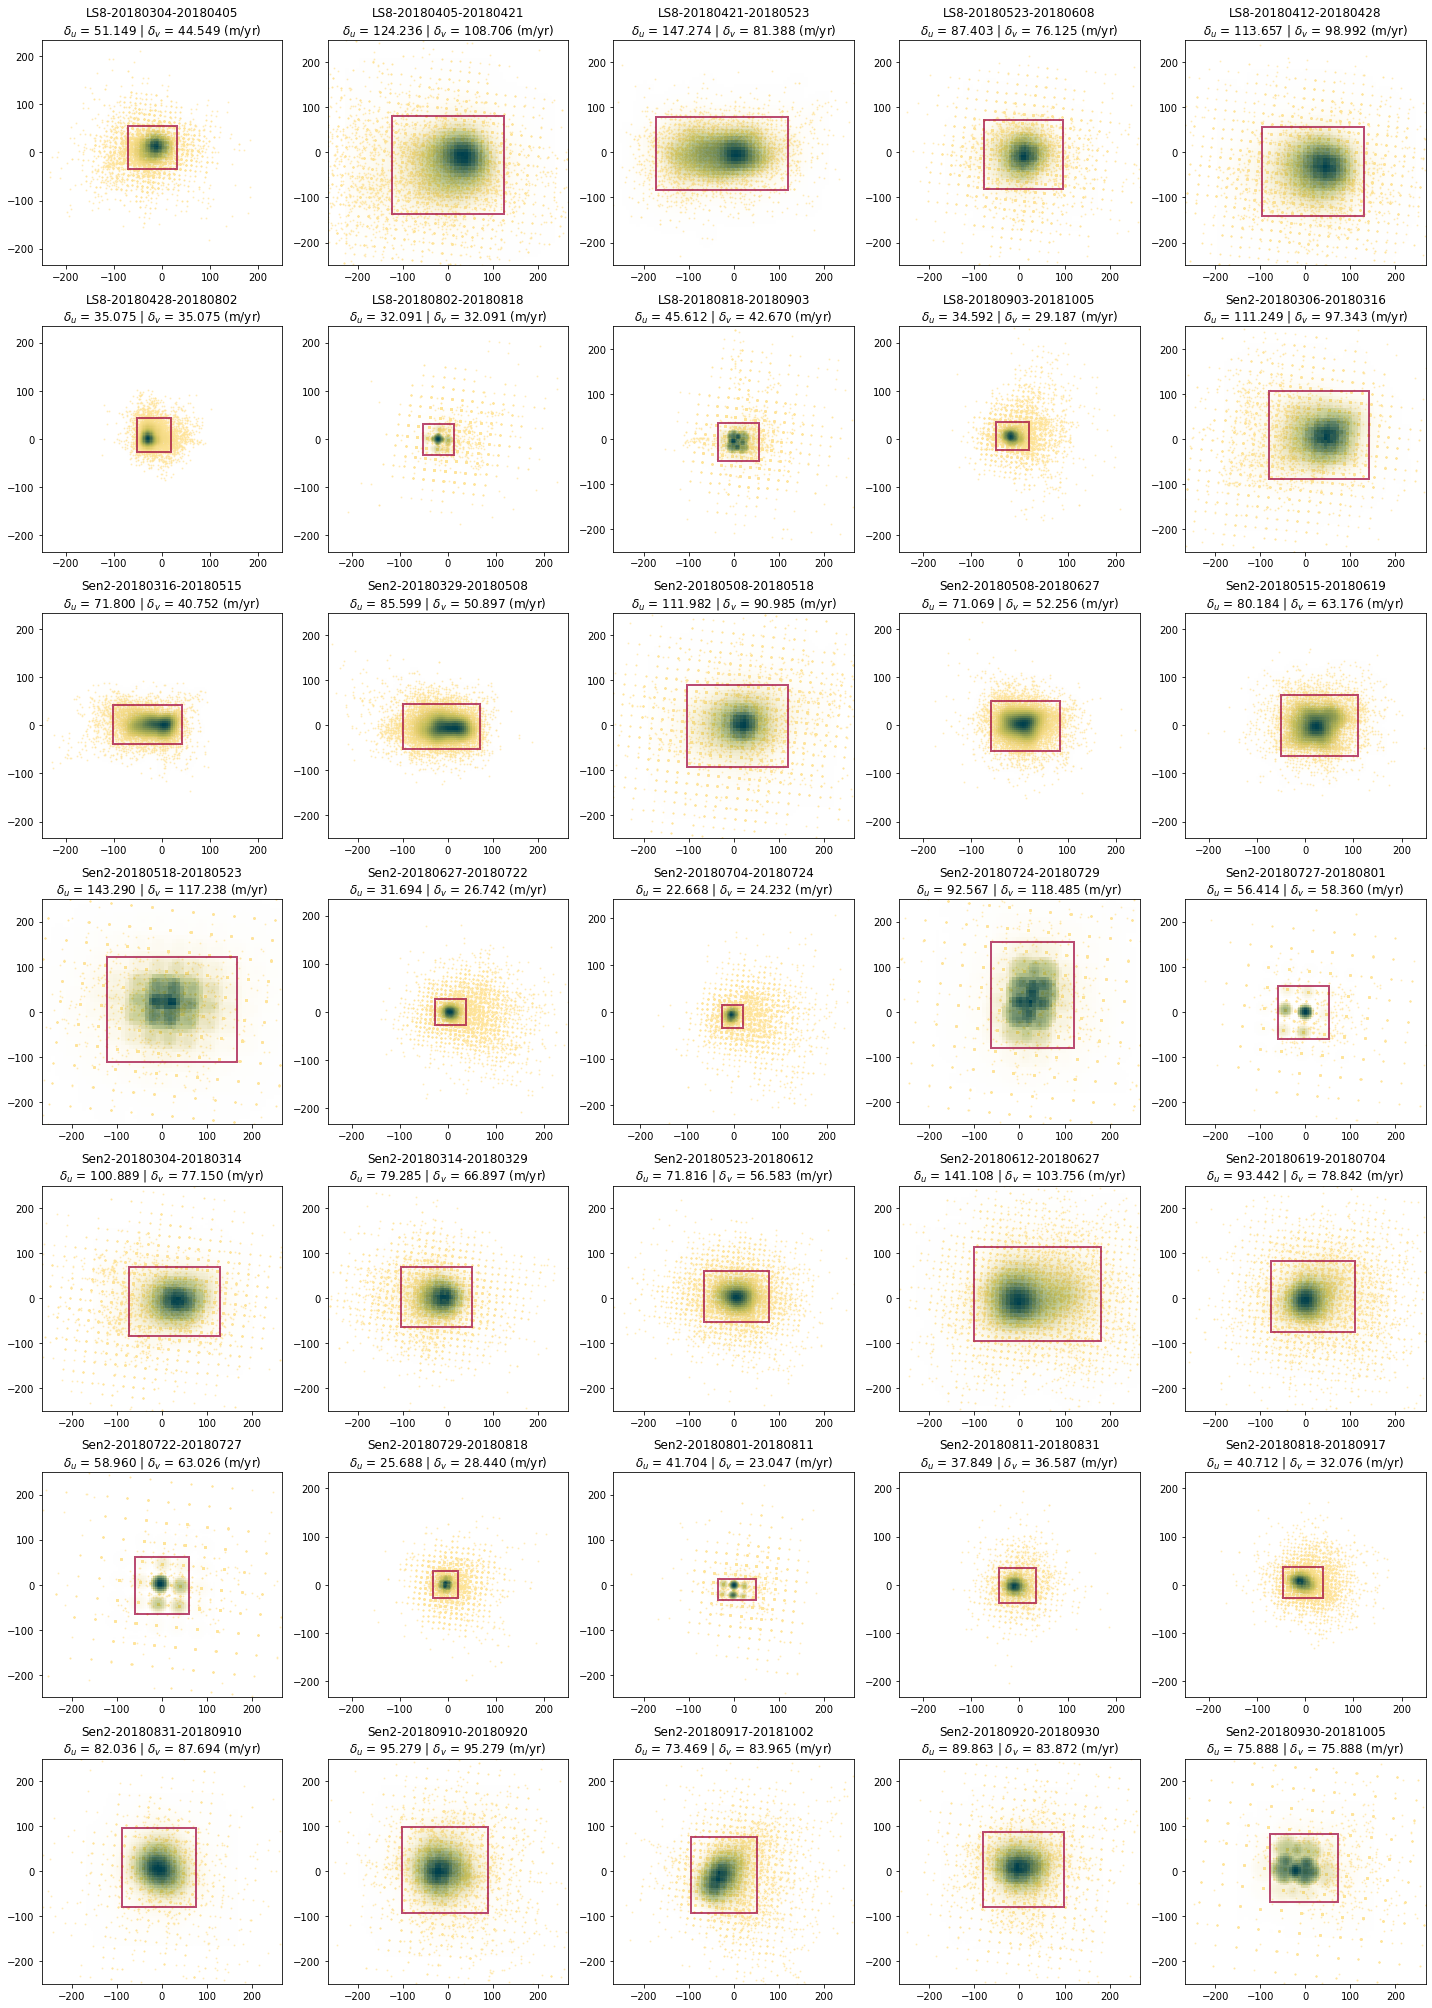

In [9]:
fig, ax2 = plt.subplots(7, 5, figsize=(20, 28))
n = 0 

for idx, row in df.iterrows():
    label = row.Label
    ax_sel = ax2[n // 5, n % 5]
    ax_sel.axis('equal')
    exp = glaft.Velocity(vxfile=row.Vx, vyfile=row.Vy, static_area=in_shp, kde_gridsize=60, thres_sigma=2.0, velocity_unit='m/yr')
    exp.static_terrain_analysis(plot='zoomed', ax=ax_sel)
    ax_sel.set_xlim(-250, 250)
    ax_sel.set_ylim(-250, 250)
    titletext = ax_sel.get_title()
    titletext = label + '\n' + titletext
    ax_sel.set_title(titletext)
    
    df.loc[idx, 'SAV-uncertainty-x'] = exp.metric_static_terrain_x
    df.loc[idx, 'SAV-uncertainty-y'] = exp.metric_static_terrain_y
    df.loc[idx, 'SAV-peak-x'] = exp.kdepeak_x
    df.loc[idx, 'SAV-peak-y'] = exp.kdepeak_y
    df.loc[idx, 'SAV-outlier-percent'] = exp.outlier_percent * 100
    
    print('xstd: {}; xSAVuncer: {}'.format(np.std(exp.xy[0, :]), exp.metric_static_terrain_x))
    print('ystd: {}; ySAVuncer: {}'.format(np.std(exp.xy[1, :]), exp.metric_static_terrain_y))
    
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
fig.savefig('figs/ITSLVE-SAV.png')

![](figs/ITSLVE-SAV.png)

In [12]:
df.to_csv('../results_ITSLIVE.csv', index=False)
# df